# Homework 1 (Support Vector Machines)

Using the data [here](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC393ParlettPelleriti/main/Data/hw1.csv), build a series of SVM models as described. Make sure that data is **z score appropriately** before fitting your models. Due to the number of models you're fitting with GridSearch, this make take a while to run.

- A. 💻 Load your data and do a 80/20 Train Test Split
- B. 💻 Use sklearn to build an SVM model. Use `GridSearchCV` to choose the `kernel` (choose from `linear` and `rbf`), `C` (choose from `[0.001, 0.01, 1, 5, 25, 50]`), and `gamma` (choose from `[0.001,0.01, 0.1, 0.5, 1,2,5]`). Print out the train and test accuracies and ROC/AUCs, and plot the train and test confusion matrices. 
- C. ✍️ What hyperparameters did GridSearch choose? (in a TEXT CELL)
- D. 💻 Use sklearn to build a Logistic Regression on the same data with the same train/test set. Print out the train and test accuracies and ROC/AUCs, and plot the train and test confusion matrices. ([CPSC 392 code](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Lectures/LectureNotebooks/Logistic_Regression_II--Class9.ipynb))
- E. 💻 Use sklearn to build a KNearest Neighbors model on the same data with the same train/test set (use GridSearch to choose `n_neighbors`).Print out the train and test accuracies and ROC/AUCs, and plot the train and test confusion matrices.   ([CPSC 392 code](https://github.com/cmparlettpelleriti/CPSC392ParlettPelleriti/blob/master/Lectures/LectureNotebooks/KNN--Class_14.ipynb))
- F. ✍️ Discuss in detail how your models performed based on the metrics you printed. Write this discussion as if you are presenting your results to a CEO/Stakeholder (in a TEXT CELL)
- G. ✍️ Compare the performance of your model to the Logistic Regression and KNN model, and provide a justification for which model you want to use "in production" (in a TEXT CELL)

In [8]:
import warnings
warnings.filterwarnings('ignore')

# data and plotting
import pandas as pd
import numpy as np
from plotnine import *

# preprocessing
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV

### A. Loading Data with a 80/20 Train Test Split

In [9]:
# importing CSV

url = "https://raw.githubusercontent.com/cmparlettpelleriti/CPSC393ParlettPelleriti/main/Data/hw1.csv"
df = pd.read_csv(url)
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Group
0,-0.604285,-0.610629,0.026014,0.019710,0.406532,0.678796,0.524360,0.404739,B
1,-0.111772,-1.125178,0.744157,0.078315,0.088176,0.891009,0.018460,0.536511,B
2,-0.916802,1.965494,0.150022,0.388770,0.179276,0.064449,0.159279,0.951204,B
3,-0.280479,0.920669,0.208949,0.940153,0.854437,0.688172,0.365126,0.985259,A
4,1.856025,1.043214,0.167088,0.207002,0.979049,0.641019,0.628764,0.045912,B


In [10]:
# checking for missing data
df.isnull().sum()

X1       0
X2       0
X3       0
X4       0
X5       0
X6       0
X7       0
X8       0
Group    0
dtype: int64

In [11]:
predictors = ["X1", "X2", "X3", "X4", "X5","X6", "X7", "X8"]

X = df[predictors]
y = df["Group"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### B. Using SKlearn to Build a SVM Model

In [12]:
z = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

svc = SVC(probability = True)

pipe = make_pipeline(z,svc)

param_grid = {
    'svc__kernel': ['linear', 'rbf'], 
    'svc__C': [0.001, 0.01, 1, 5, 25, 50], 
    'svc__gamma': [0.001, 0.01, 0.1, 0.5, 1, 2, 5]
}

# GridSearchCV for Hyperparameter Tuning
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, refit = True)

# Fitting Model
grid.fit(X_train, y_train)

# Best Parameters
print("Best hyperparameters: ", grid.best_params_)

print(grid.best_estimator_.get_params()["svc__kernel"])
print(grid.best_estimator_.get_params()["svc__C"])
print(grid.best_estimator_.get_params()["svc__gamma"])

print("Train Acc:", accuracy_score(y_train, grid.predict(X_train)))
print("Test Acc :", accuracy_score(y_test, grid.predict(X_test)))

print("Train AUC:", roc_auc_score(y_train, grid.predict_proba(X_train)[:,1]))
print("Test AUC :", roc_auc_score(y_test, grid.predict_proba(X_test)[:,1]))


Best hyperparameters:  {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'linear'}
linear
1
0.001
Train Acc: 0.76375
Test Acc : 0.76
Train AUC: 0.8457098446269813
Test AUC : 0.8318965517241379


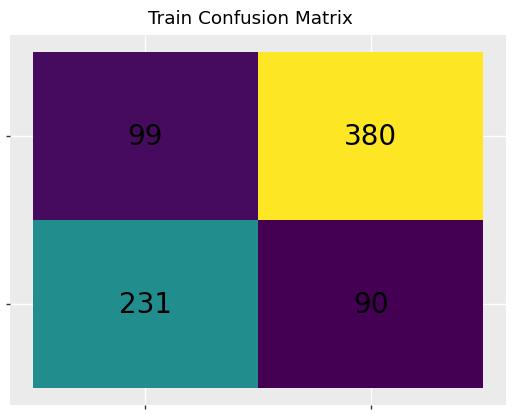

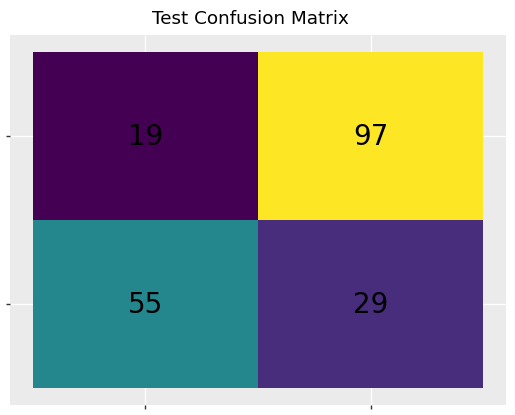

In [14]:
# Predictions
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

# Confusion matrices
train_confusion_matrix = confusion_matrix(y_train, y_train_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

# Plot train confusion matrix
train_cm_df = pd.DataFrame(train_confusion_matrix, columns=["Predicted Negative", "Predicted Positive"], index=["Actual Negative", "Actual Positive"])
train_cm_df = train_cm_df.stack().reset_index()
train_cm_df.columns = ["Actual", "Predicted", "Count"]
train_cm_plot = (ggplot(train_cm_df, aes(x="Predicted", y="Actual", fill="Count")) +
                 geom_tile() +
                 geom_text(aes(label="Count"), color="black", size=20) +
                 theme(legend_position="none",
                       axis_text_x=element_blank(),
                       axis_text_y=element_blank(),
                       axis_title_x=element_blank(),
                       axis_title_y=element_blank()) +
                 labs(title="Train Confusion Matrix"))
print(train_cm_plot)

# Plot test confusion matrix
test_cm_df = pd.DataFrame(test_confusion_matrix, columns=["Predicted Negative", "Predicted Positive"], index=["Actual Negative", "Actual Positive"])
test_cm_df = test_cm_df.stack().reset_index()
test_cm_df.columns = ["Actual", "Predicted", "Count"]
test_cm_plot = (ggplot(test_cm_df, aes(x="Predicted", y="Actual", fill="Count")) +
                geom_tile() +
                geom_text(aes(label="Count"), color="black", size=20) +
                theme(legend_position="none",
                      axis_text_x=element_blank(),
                      axis_text_y=element_blank(),
                      axis_title_x=element_blank(),
                      axis_title_y=element_blank()) +
                labs(title="Test Confusion Matrix"))
print(test_cm_plot)